# Credit Card Fraud Detection - BFSI Domain

## Project Overview
This notebook demonstrates fraud detection in Banking, Financial Services, and Insurance (BFSI) domain using machine learning techniques. We'll explore transaction patterns, identify fraud indicators, and build predictive models.

**Key Learning Objectives:**
- Understand fraud patterns in financial transactions
- Handle highly imbalanced datasets
- Engineer features for fraud detection
- Compare different ML models for classification
- Interpret results in business context

---

## 1. Import Libraries and Setup

In [4]:
# Install required library for geospatial distance calculations
%pip install geopy



   ---------------------------------------- 0/2 [geographiclib]
   -------------------- ------------------- 1/2 [geopy]
   -------------------- ------------------- 1/2 [geopy]
   -------------------- ------------------- 1/2 [geopy]
   -------------------- ------------------- 1/2 [geopy]
   ---------------------------------------- 2/2 [geopy]

Note: you may need to restart the kernel to use updated packages.


In [5]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from geopy.distance import geodesic
import warnings
warnings.filterwarnings('ignore')

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

# Load dataset
df = pd.read_csv("fraudTest.csv")

# Initial look at the data
print(f"Dataset shape: {df.shape}")
print(f"\nColumn names:\n{df.columns.tolist()}")
df.head()


Dataset shape: (555719, 23)

Column names:
['Unnamed: 0', 'trans_date_trans_time', 'cc_num', 'merchant', 'category', 'amt', 'first', 'last', 'gender', 'street', 'city', 'state', 'zip', 'lat', 'long', 'city_pop', 'job', 'dob', 'trans_num', 'unix_time', 'merch_lat', 'merch_long', 'is_fraud']


,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2020-06-21 12:14:25,2291163933867244,fraud_Kirlin and Sons,personal_care,2.86,Jeff,Elliott,M,351 Darlene Green,Columbia,SC,29209,33.9659,-80.9355,333497,Mechanical engineer,1968-03-19,2da90c7d74bd46a0caf3777415b3ebd3,1371816865,33.986391,-81.200714,0
1,1,2020-06-21 12:14:33,3573030041201292,fraud_Sporer-Keebler,personal_care,29.84,Joanne,Williams,F,3638 Marsh Union,Altonah,UT,84002,40.3207,-110.4360,302,"Sales professional, IT",1990-01-17,324cc204407e99f51b0d6ca0055005e7,1371816873,39.450498,-109.960431,0
2,2,2020-06-21 12:14:53,3598215285024754,"fraud_Swaniawski, Nitzsche and Welch",health_fitness,41.28,Ashley,Lopez,F,9333 Valentine Point,Bellmore,NY,11710,40.6729,-73.5365,34496,"Librarian, public",1970-10-21,c81755dbbbea9d5c77f094348a7579be,1371816893,40.495810,-74.196111,0
3,3,2020-06-21 12:15:15,3591919803438423,fraud_Haley Group,misc_pos,60.05,Brian,Williams,M,32941 Krystal Mill Apt. 552,Titusville,FL,32780,28.5697,-80.8191,54767,Set designer,1987-07-25,2159175b9efe66dc301f149d3d5abf8c,1371816915,28.812398,-80.883061,0
4,4,2020-06-21 12:15:17,3526826139003047,fraud_Johnston-Casper,travel,3.19,Nathan,Massey,M,5783 Evan Roads Apt. 465,Falmouth,MI,49632,44.2529,-85.0170,1126,Furniture designer,1955-07-06,57ff021bd3f328f8738bb535c302a31b,1371816917,44.959148,-85.884734,0


## 2. Data Understanding

**Why this matters:** Understanding the data structure helps identify what features are available for fraud detection and which ones might be personally identifiable information (PII) that should be handled carefully.

In [6]:
# Remove index column if present
if 'Unnamed: 0' in df.columns:
    df = df.drop(columns=['Unnamed: 0'])

# Check dataset info
print("=== Dataset Information ===")
print(f"Total transactions: {len(df):,}")
print(f"Total features: {df.shape[1]}")
print(f"\nMissing values per column:")
print(df.isnull().sum().sum())  # Total missing values
print(f"\nDuplicate rows: {df.duplicated().sum()}")

# Quick statistical summary
df.describe()

=== Dataset Information ===
Total transactions: 555,719
Total features: 22

Missing values per column:
0

Duplicate rows: 0


,cc_num,amt,zip,lat,long,city_pop,unix_time,merch_lat,merch_long,is_fraud
count,5.557190e+05,555719.000000,555719.000000,555719.000000,555719.000000,5.557190e+05,5.557190e+05,555719.000000,555719.000000,555719.000000
mean,4.178387e+17,69.392810,48842.628015,38.543253,-90.231325,8.822189e+04,1.380679e+09,38.542798,-90.231380,0.003860
std,1.309837e+18,156.745941,26855.283328,5.061336,13.721780,3.003909e+05,5.201104e+06,5.095829,13.733071,0.062008
min,6.041621e+10,1.000000,1257.000000,20.027100,-165.672300,2.300000e+01,1.371817e+09,19.027422,-166.671575,0.000000
25%,1.800429e+14,9.630000,26292.000000,34.668900,-96.798000,7.410000e+02,1.376029e+09,34.755302,-96.905129,0.000000
50%,3.521417e+15,47.290000,48174.000000,39.371600,-87.476900,2.408000e+03,1.380762e+09,39.376593,-87.445204,0.000000
75%,4.635331e+15,83.010000,72011.000000,41.894800,-80.175200,1.968500e+04,1.385867e+09,41.954163,-80.264637,0.000000
max,4.992346e+18,22768.110000,99921.000000,65.689900,-67.950300,2.906700e+06,1.388534e+09,66.679297,-66.952026,1.000000


In [7]:
# Check target variable distribution
print("=== Target Variable Distribution ===")
fraud_counts = df['is_fraud'].value_counts()
fraud_pct = df['is_fraud'].value_counts(normalize=True) * 100

print(f"Non-Fraud: {fraud_counts[0]:,} ({fraud_pct[0]:.2f}%)")
print(f"Fraud: {fraud_counts[1]:,} ({fraud_pct[1]:.2f}%)")
print(f"\n⚠️ Class Imbalance Ratio: {fraud_counts[0]/fraud_counts[1]:.1f}:1")

=== Target Variable Distribution ===
Non-Fraud: 553,574 (99.61%)
Fraud: 2,145 (0.39%)

⚠️ Class Imbalance Ratio: 258.1:1


## 3. Data Preprocessing

**Why this step matters:** Raw data often has incorrect data types and missing values. Proper preprocessing ensures our models can learn effectively from clean data.

In [8]:
# Fix data types
# Convert datetime columns
df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'], errors='coerce')
df['dob'] = pd.to_datetime(df['dob'], errors='coerce')

# Convert zip to string (it's a categorical identifier, not numeric)
df['zip'] = df['zip'].astype(str)

print("✓ Data types corrected")
print(f"✓ Date columns converted to datetime")
print(f"✓ Categorical identifiers converted to string")


✓ Data types corrected
✓ Date columns converted to datetime
✓ Categorical identifiers converted to string


## 4. Feature Engineering

**Why Feature Engineering?** Raw features like timestamps and coordinates aren't directly useful. We extract meaningful patterns like "transaction hour" or "distance from home" that reveal fraud behavior.

In [9]:
# Convert to datetime
df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'], errors='coerce')

df['dob'] = pd.to_datetime(df['dob'], errors='coerce')

# Convert target to category
# df['is_fraud'] = df['is_fraud'].astype('category')

# Convert zip to string (since it’s not numeric in nature)
df['zip'] = df['zip'].astype(str)

# df
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 555719 entries, 0 to 555718
Data columns (total 22 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   trans_date_trans_time  555719 non-null  datetime64[ns]
 1   cc_num                 555719 non-null  int64         
 2   merchant               555719 non-null  object        
 3   category               555719 non-null  object        
 4   amt                    555719 non-null  float64       
 5   first                  555719 non-null  object        
 6   last                   555719 non-null  object        
 7   gender                 555719 non-null  object        
 8   street                 555719 non-null  object        
 9   city                   555719 non-null  object        
 10  state                  555719 non-null  object        
 11  zip                    555719 non-null  object        
 12  lat                    555719 non-null  floa

In [10]:
# Extract time-based features
# Why: Fraud patterns vary by time (e.g., more fraud at night)
df['hour'] = df['trans_date_trans_time'].dt.hour
df['day'] = df['trans_date_trans_time'].dt.day
df['weekday'] = df['trans_date_trans_time'].dt.weekday

# Calculate customer age
# Why: Age can correlate with fraud vulnerability or spending patterns
df['age'] = (pd.Timestamp.now().year - df['dob'].dt.year)

# Calculate distance between customer and merchant
# Why: Unusual distance (card used far from home) is a fraud indicator
df['distance'] = df.apply(
    lambda x: geodesic((x['lat'], x['long']), (x['merch_lat'], x['merch_long'])).km, 
    axis=1
)

# Identify online transactions
# Why: Online transactions have higher fraud risk (card-not-present)
df['is_online'] = df['category'].apply(lambda x: 1 if 'net' in x else 0)

print("✓ Engineered features:")
print("  - Time features: hour, day, weekday")
print("  - Customer age")
print("  - Customer-merchant distance")
print("  - Online transaction indicator")


✓ Engineered features:
  - Time features: hour, day, weekday
  - Customer age
  - Customer-merchant distance
  - Online transaction indicator


## 5. Exploratory Data Analysis (EDA)

**Why EDA?** Before modeling, we need to understand:
- Distribution of features (skewed or normal?)
- Class imbalance severity
- Which features correlate with fraud
- Outliers that might need treatment

### 5.1 Target Variable Distribution

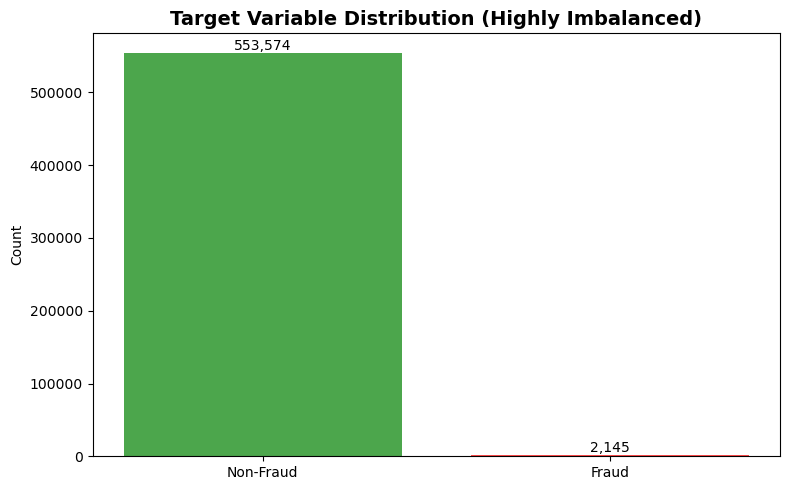

💡 Key Insight: Dataset is highly imbalanced (~99.6% non-fraud)
   This reflects real-world scenarios where fraud is rare.
   We'll need to handle this using techniques like class weighting or SMOTE.


In [11]:
# Visualize class imbalance
plt.figure(figsize=(8, 5))
fraud_counts = df['is_fraud'].value_counts()
bars = plt.bar(['Non-Fraud', 'Fraud'], fraud_counts, color=['green', 'red'], alpha=0.7)
plt.title('Target Variable Distribution (Highly Imbalanced)', fontsize=14, weight='bold')
plt.ylabel('Count')

# Add count labels on bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height):,}',
             ha='center', va='bottom')

plt.tight_layout()
plt.show()

print("💡 Key Insight: Dataset is highly imbalanced (~99.6% non-fraud)")
print("   This reflects real-world scenarios where fraud is rare.")
print("   We'll need to handle this using techniques like class weighting or SMOTE.")


### 5.2 Key Feature Distributions

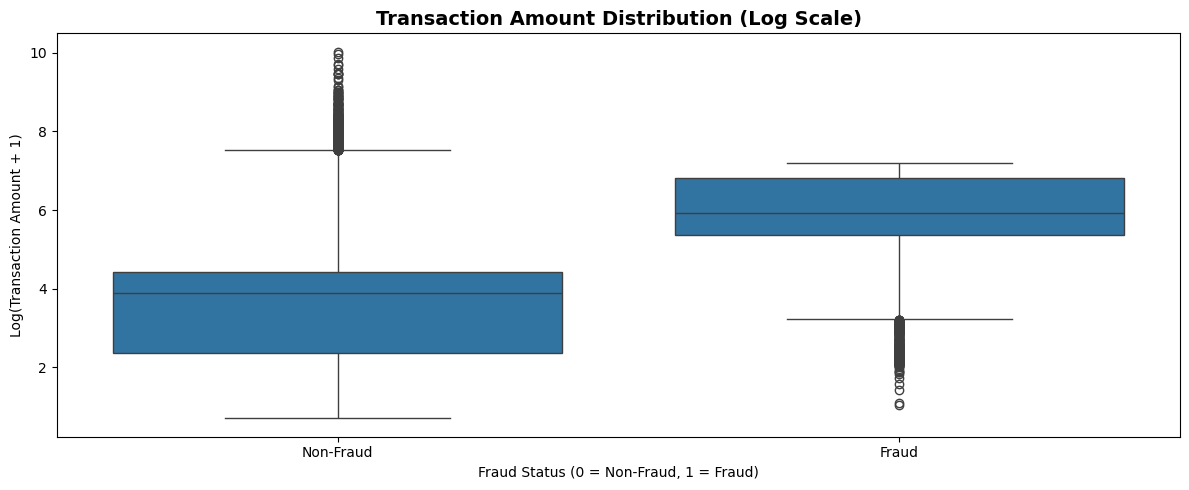

💡 Insight: Fraud transactions tend to have slightly higher amounts on average.
   However, there's significant overlap, so amount alone isn't sufficient.


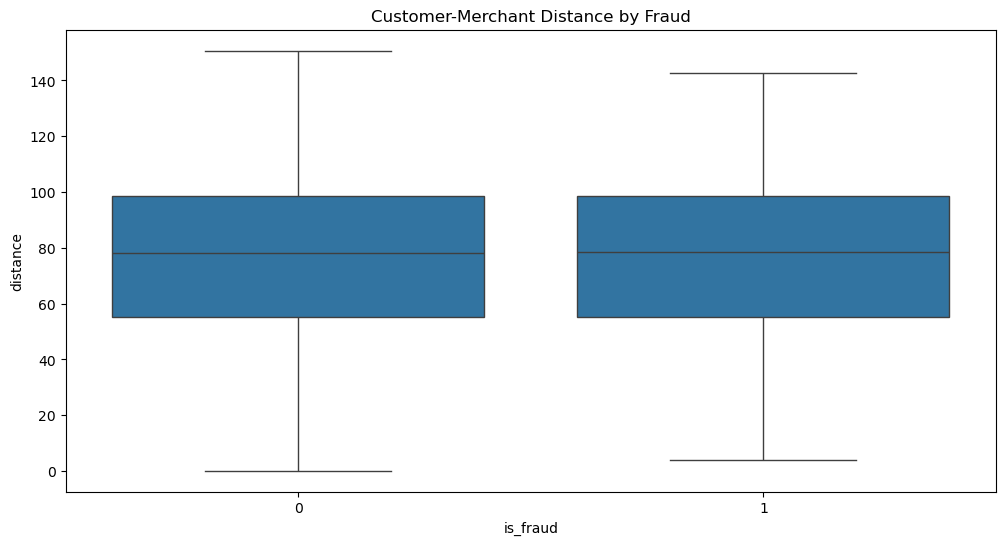

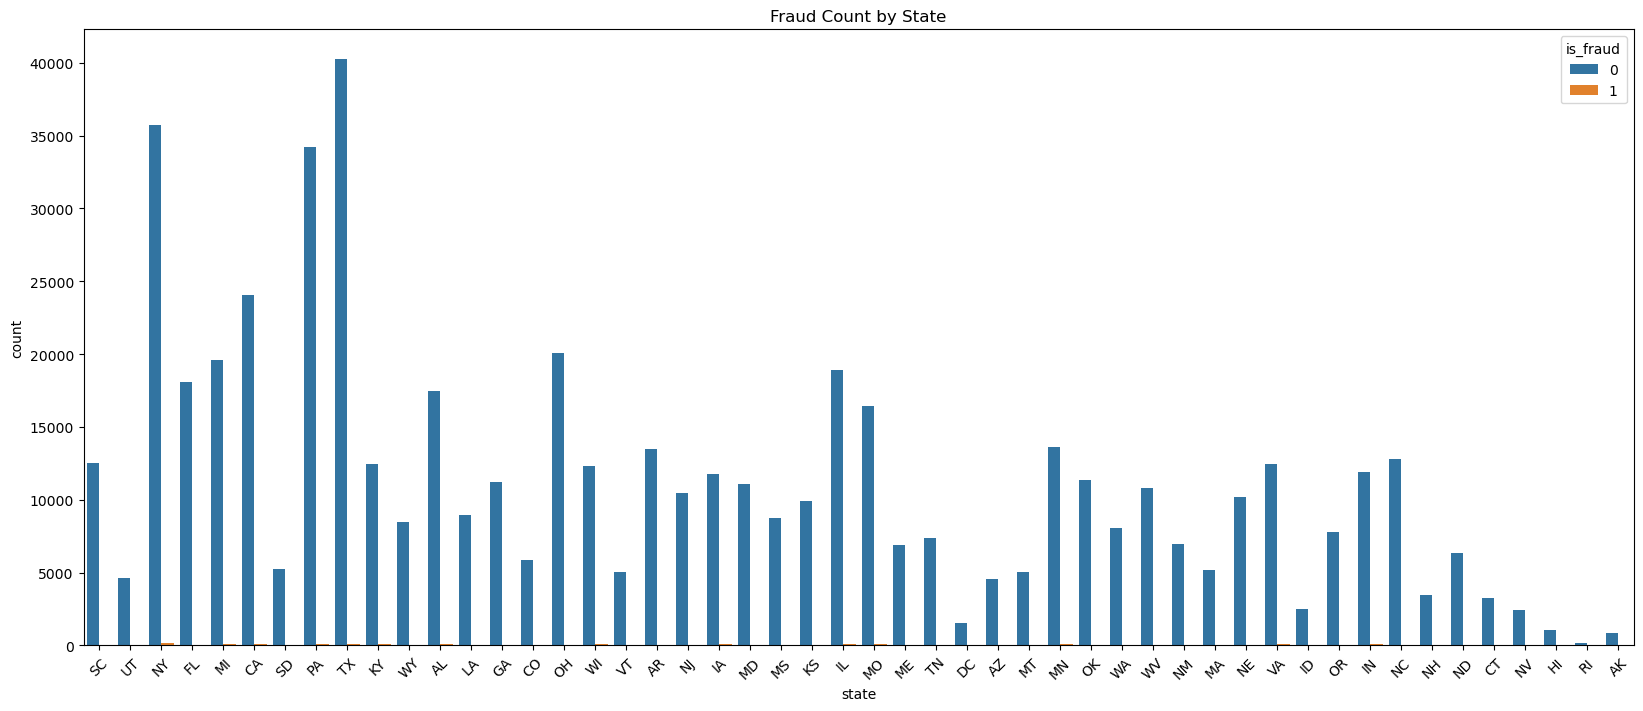

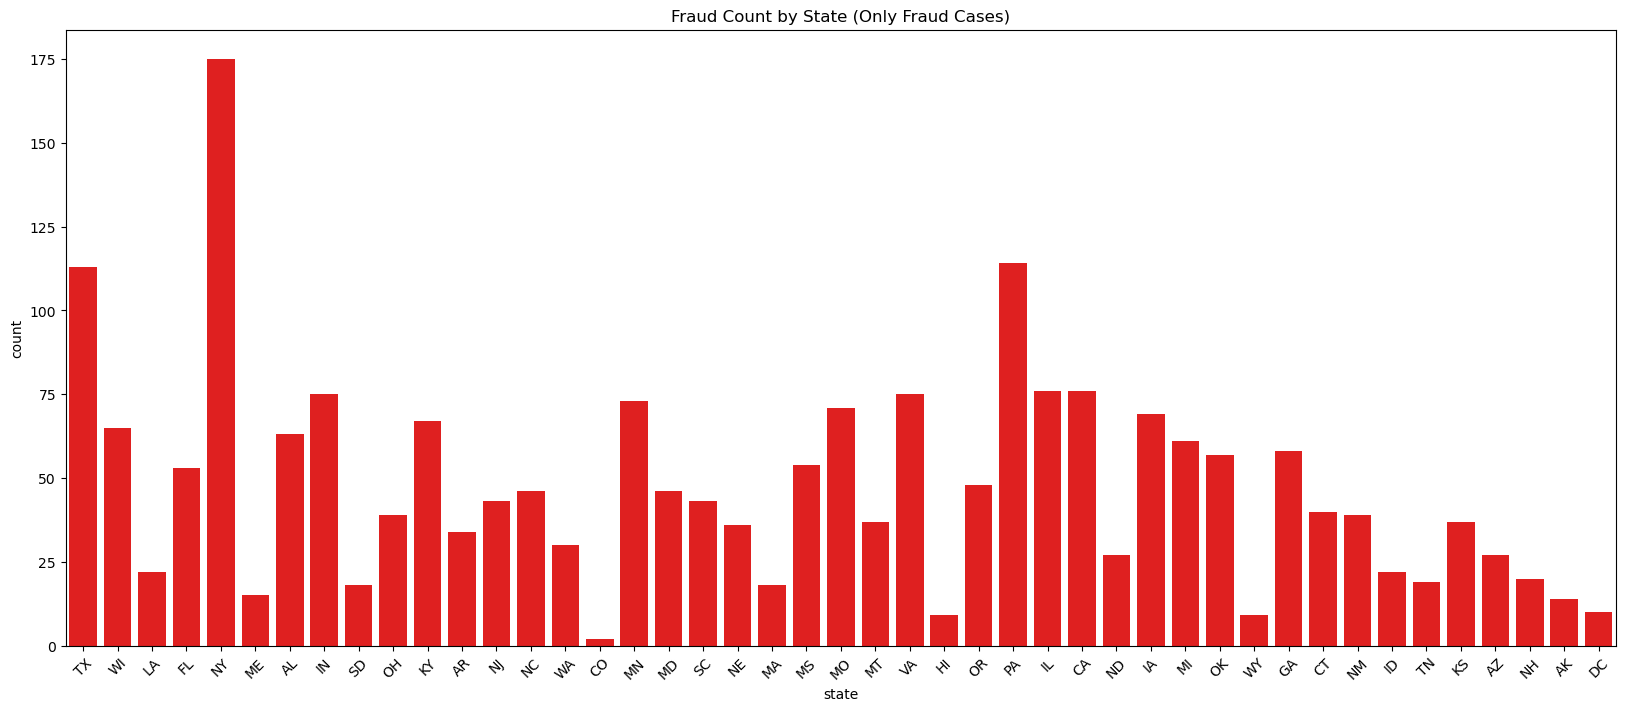

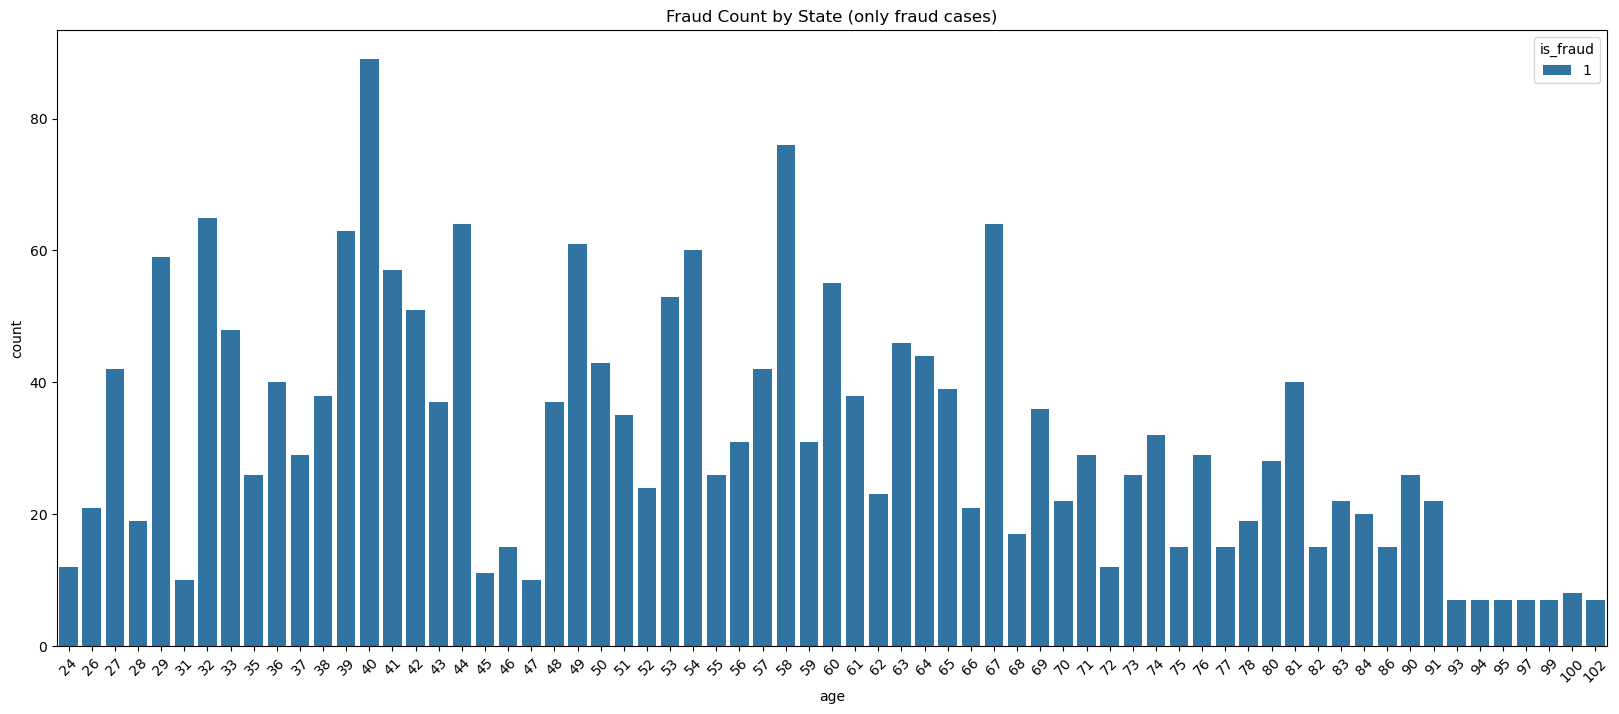

In [12]:
# # Transaction amount vs fraud
# plt.figure(figsize=(12,6))
# sns.boxplot(x='is_fraud', y='amt', data=df)
# plt.title('Transaction Amount by Fraud Status')
# plt.show()


# #doing below in log scale as the data is highly skwed
# plt.figure(figsize=(12,6))
# sns.boxplot(x='is_fraud', y=np.log1p(df['amt']), data=df)
# plt.title('Transaction Amount (Log Scale) by Fraud Status')
# plt.ylabel('Log(Transaction Amount)')
# plt.xlabel('Fraud Status (0 = Genuine, 1 = Fraud)')
# plt.show()



#in graph 1, amt vs is_fraud
# What we see:
# Most non-fraud transactions (is_fraud=0) have very small amounts — but a few large outliers (very high amounts).
# Fraud transactions (is_fraud=1) have slightly higher median amounts (the box is shifted upward).
# Fraud boxplot is tighter → fewer but higher-value transactions, while non-fraud has a wider spread and more outliers.
# Interpretation:
# Fraud transactions often involve unusually high amounts compared to normal transactions.
# The median transaction amount for fraud is higher, even if fewer in count.
# Outliers among non-fraud can also represent legitimate large purchases, so we shouldn’t remove them blindly — they may carry predictive value.
# Actionable takeaway:
# “Transaction amount” is a strong predictor of fraud likelihood.

# Consider log-transforming amt to reduce skewness before modeling


#online category
#amt
#hour/time of the time are some dominant features, use sin cos
#and do smote for lineae regression or random forest 


#what is random bias variancce trade off 

#always remove personal data, the model need not know about the personal details
#remove the lag long details

#xgboost has calse post weight, it will give weight to minorty.... dont use smoott whiihc itseld is a bias to minorty data....



# Analyze transaction amount vs fraud
plt.figure(figsize=(12, 5))
sns.boxplot(x='is_fraud', y=np.log1p(df['amt']), data=df)
plt.title('Transaction Amount Distribution (Log Scale)', fontsize=14, weight='bold')
plt.ylabel('Log(Transaction Amount + 1)')
plt.xlabel('Fraud Status (0 = Non-Fraud, 1 = Fraud)')
plt.xticks([0, 1], ['Non-Fraud', 'Fraud'])
plt.tight_layout()
plt.show()

print("💡 Insight: Fraud transactions tend to have slightly higher amounts on average.")
print("   However, there's significant overlap, so amount alone isn't sufficient.")

# in graph 2, fraud count by category 
# What we see:
# Fraud (orange) is present in almost every category, but the count is tiny compared to non-fraud.
# Certain categories (like shopping_net, misc_net, travel) appear to have a slightly higher number of fraud cases relative to others.
# Categories like gas_transport, grocery_pos are mostly legitimate (few or no frauds).
# Interpretation (Domain View):
# Online-related categories (e.g., shopping_net, misc_net) tend to have higher fraud rates, consistent with BFSI experience (card-not-present frauds).
# In-person or low-value categories (like gas, groceries) have very low fraud — less incentive or harder to commit.
# Actionable takeaway:
# The category feature is highly informative.
# You can engineer features like

# df['is_online'] = df['category'].apply(lambda x: 1 if 'net' in x else 0)
# df['category_risk'] = df['category'].map({'shopping_net': 3, 'misc_net': 3, 'travel': 2, 'grocery_pos': 1, ...})






# Distance vs Fraud
plt.figure(figsize=(12,6))
sns.boxplot(x='is_fraud', y='distance', data=df)
plt.title('Customer-Merchant Distance by Fraud')
plt.show()

# in graph 3 Distance vs Fraud (distance vs is_fraud)
# What we see:
# Both fraud and non-fraud distributions are roughly similar — median around ~75–80 distance units.
# The spread (IQR) for fraud and non-fraud is also similar — indicating distance alone doesn’t differentiate them strongly.
# Slightly higher median for fraud → possibly minor correlation.
# Interpretation:
# Distance may not be a strong standalone predictor — fraudsters sometimes transact from close or far locations randomly.
# But in combination with other features (time of day, merchant type, frequency), it could still add predictive power.



#state vs fraud
plt.figure(figsize=(20,8))
sns.countplot(x='state', hue='is_fraud', data=df)
plt.xticks(rotation=45)
plt.title('Fraud Count by State')
plt.show()



fraud_df = df[df['is_fraud'] == 1]

plt.figure(figsize=(20, 8))
ax = sns.countplot(x='state', data=fraud_df, color='red')
plt.xticks(rotation=45)
plt.title('Fraud Count by State (Only Fraud Cases)')



#age vs fraud
fraud_df = df[df['is_fraud'] == 1]
plt.figure(figsize=(20,8))
sns.countplot(x='age', hue='is_fraud', data=fraud_df)
plt.xticks(rotation=45)
plt.title('Fraud Count by State (only fraud cases)')
plt.show()

# amt vs fraud
# fraud_df = df[df['is_fraud'] == 1]
# plt.figure(figsize=(20,8))
# sns.countplot(x='amt', hue='is_fraud', data=fraud_df)
# plt.xticks(rotation=45)
# plt.title('Fraud Count by State (only fraud cases)')
# plt.show()

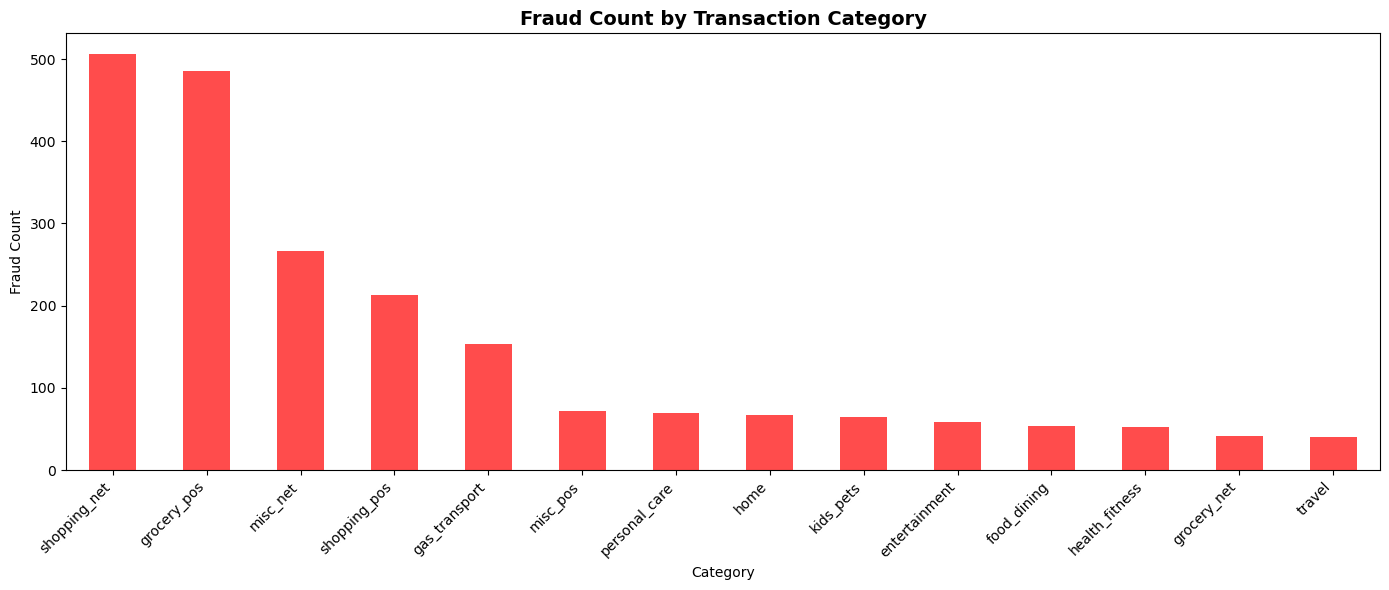

💡 Insight: Online categories (shopping_net, misc_net) have higher fraud counts.
   This makes sense as 'card-not-present' transactions are riskier.


In [13]:
# Analyze fraud by transaction category
fraud_by_category = df[df['is_fraud'] == 1]['category'].value_counts()

plt.figure(figsize=(14, 6))
fraud_by_category.plot(kind='bar', color='red', alpha=0.7)
plt.title('Fraud Count by Transaction Category', fontsize=14, weight='bold')
plt.xlabel('Category')
plt.ylabel('Fraud Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

print("💡 Insight: Online categories (shopping_net, misc_net) have higher fraud counts.")
print("   This makes sense as 'card-not-present' transactions are riskier.")


# Analyze fraud by transaction hour
fraud_by_hour = df[df['is_fraud'] == 1].groupby('hour').size()
total_by_hour = df.groupby('hour').size()
fraud_rate_by_hour = (fraud_by_hour / total_by_hour * 100).fillna(0)

plt.figure(figsize=(14, 5))
plt.plot(fraud_rate_by_hour.index, fraud_rate_by_hour.values, marker='o', color='red', linewidth=2)
plt.title('Fraud Rate by Hour of Day', fontsize=14, weight='bold')
plt.xlabel('Hour of Day')
plt.ylabel('Fraud Rate (%)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("💡 Insight: Fraud rates vary by time of day.")
print("   Late night/early morning hours may show different patterns.") 

### 5.3 Correlation Analysis

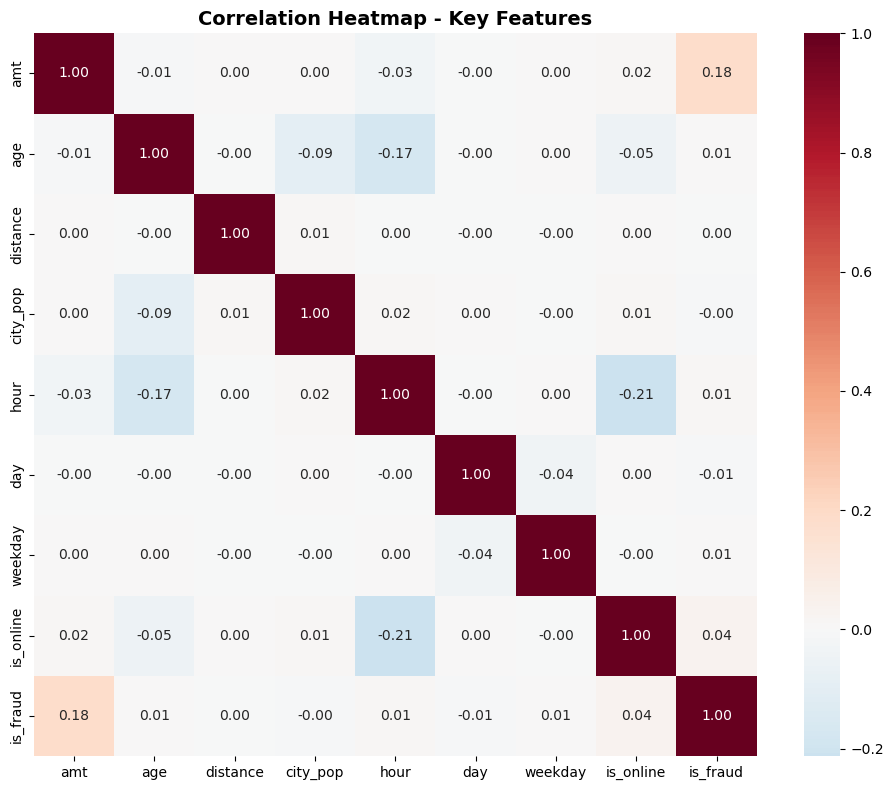

💡 Insight: Look for features with strong correlation to 'is_fraud'.
   These will be important predictors in our models.


In [14]:
# Select key numerical features for correlation
key_features = ['amt', 'age', 'distance', 'city_pop', 'hour', 'day', 'weekday', 'is_online', 'is_fraud']
corr = df[key_features].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='RdBu_r', center=0, fmt='.2f', square=True)
plt.title('Correlation Heatmap - Key Features', fontsize=14, weight='bold')
plt.tight_layout()
plt.show()

print("💡 Insight: Look for features with strong correlation to 'is_fraud'.")
print("   These will be important predictors in our models.")


## 6. Data Preprocessing for Modeling

### 6.1 Outlier Treatment

**Why handle outliers?** Extreme values can skew model learning. However, in fraud detection, some outliers might be actual fraud cases, so we cap rather than remove them.

In [15]:
# The “box” in a boxplot represents the interquartile range (IQR) — the middle 50% of your data.
# However, in our case:
# Most transaction amounts (amt) are very small (say ₹5, ₹20, ₹200).
# A few transactions are huge (5,000 to 20,000).
# These big outliers stretch the y-axis scale so much that the main box (small values) looks compressed into a thin line near 0.

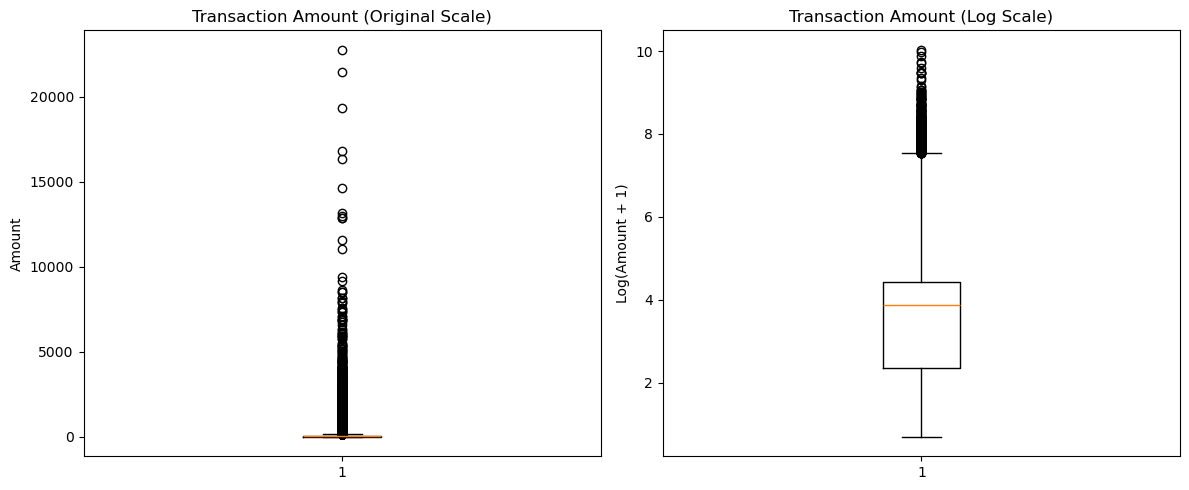

💡 Many outliers visible - we'll cap them using IQR method.


In [16]:
# Visualize outliers in transaction amount
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Regular scale
axes[0].boxplot(df['amt'])
axes[0].set_title('Transaction Amount (Original Scale)')
axes[0].set_ylabel('Amount')

# Log scale for better visualization
axes[1].boxplot(np.log1p(df['amt']))
axes[1].set_title('Transaction Amount (Log Scale)')
axes[1].set_ylabel('Log(Amount + 1)')

plt.tight_layout()
plt.show()

print("💡 Many outliers visible - we'll cap them using IQR method.")


In [17]:
# Cap outliers using IQR (Interquartile Range) method
Q1 = df['amt'].quantile(0.25)
Q3 = df['amt'].quantile(0.75)
IQR = Q3 - Q1

# Define outlier boundaries
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print(f"Outlier boundaries: [{lower_bound:.2f}, {upper_bound:.2f}]")
print(f"Values outside these will be capped.")

# Cap extreme values (don't remove them - they might be legitimate)
df['amt'] = np.where(df['amt'] > upper_bound, upper_bound,
                     np.where(df['amt'] < lower_bound, lower_bound, df['amt']))

print("✓ Outliers capped successfully")

Outlier boundaries: [-100.44, 193.08]
Values outside these will be capped.
✓ Outliers capped successfully


### 6.2 Feature Encoding

**Why encode?** Machine learning models work with numbers, not text. We need to convert categorical features (like 'category', 'gender') into numerical format.

In [18]:
# Check unique values for categorical features
print("Unique values in key categorical features:")
print(f"  - Gender: {df['gender'].nunique()}")
print(f"  - Category: {df['category'].nunique()}")
print(f"  - State: {df['state'].nunique()}")
print(f"  - Merchant: {df['merchant'].nunique()} (too many for one-hot)")
print(f"  - Job: {df['job'].nunique()} (too many for one-hot)")




Unique values in key categorical features:
  - Gender: 2
  - Category: 14
  - State: 50
  - Merchant: 693 (too many for one-hot)
  - Job: 478 (too many for one-hot)


In [19]:
# One-hot encode low-cardinality categorical features
# Why: Creates binary columns for each category (e.g., gender_M, gender_F)
# drop_first=True avoids multicollinearity (dummy variable trap)
df = pd.get_dummies(df, columns=['category', 'gender', 'state'], drop_first=True, dtype=int)

print(f"✓ One-hot encoded: category, gender, state")
print(f"  New shape: {df.shape}")

✓ One-hot encoded: category, gender, state
  New shape: (555719, 88)


In [21]:
# Note: One-hot encoding already done in previous cell
# This cell now only handles merchant frequency encoding

# Frequency encoding for high-cardinality features (like merchant)
merchant_freq = df['merchant'].value_counts().to_dict()
df['merchant_freq'] = df['merchant'].map(merchant_freq)
df.drop('merchant', axis=1, inplace=True)

df.head()

# state_TX = 1 means transaction happened in Texas
# state_TX = 0 means transaction did not happen in Texas


# One-hot encoding works for small sets of categories. 
#Frequency encoding helps when there are hundreds of merchant names.


# we dont use Label Encoding as its used only when the categories are ordinal, like school<college whre order matters
# In BFSI datasets, most categorical variables are nominal — meaning they have no natural order. So if you use Label Encoding:
# The model might think “category = 2” is greater or has higher risk than “category = 1”, which is wrong.
# It adds fake numeric order → distorts patterns and misleads linear or distance-based  ML models.

,trans_date_trans_time,cc_num,amt,first,last,street,city,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud,hour,day,weekday,age,distance,is_online,category_food_dining,category_gas_transport,category_grocery_net,category_grocery_pos,category_health_fitness,category_home,category_kids_pets,category_misc_net,category_misc_pos,category_personal_care,category_shopping_net,category_shopping_pos,category_travel,gender_M,state_AL,state_AR,state_AZ,state_CA,state_CO,state_CT,state_DC,state_FL,state_GA,state_HI,state_IA,state_ID,state_IL,state_IN,state_KS,state_KY,state_LA,state_MA,state_MD,state_ME,state_MI,state_MN,state_MO,state_MS,state_MT,state_NC,state_ND,state_NE,state_NH,state_NJ,state_NM,state_NV,state_NY,state_OH,state_OK,state_OR,state_PA,state_RI,state_SC,state_SD,state_TN,state_TX,state_UT,state_VA,state_VT,state_WA,state_WI,state_WV,state_WY,merchant_freq
0,2020-06-21 12:14:25,2291163933867244,2.86,Jeff,Elliott,351 Darlene Green,Columbia,29209,33.9659,-80.9355,333497,Mechanical engineer,1968-03-19,2da90c7d74bd46a0caf3777415b3ebd3,1371816865,33.986391,-81.200714,0,12,21,6,58,24.613746,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,736
1,2020-06-21 12:14:33,3573030041201292,29.84,Joanne,Williams,3638 Marsh Union,Altonah,84002,40.3207,-110.4360,302,"Sales professional, IT",1990-01-17,324cc204407e99f51b0d6ca0055005e7,1371816873,39.450498,-109.960431,0,12,21,6,36,104.834043,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,785
2,2020-06-21 12:14:53,3598215285024754,41.28,Ashley,Lopez,9333 Valentine Point,Bellmore,11710,40.6729,-73.5365,34496,"Librarian, public",1970-10-21,c81755dbbbea9d5c77f094348a7579be,1371816893,40.495810,-74.196111,0,12,21,6,56,59.204796,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,755
3,2020-06-21 12:15:15,3591919803438423,60.05,Brian,Williams,32941 Krystal Mill Apt. 552,Titusville,32780,28.5697,-80.8191,54767,Set designer,1987-07-25,2159175b9efe66dc301f149d3d5abf8c,1371816915,28.812398,-80.883061,0,12,21,6,39,27.615117,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,711
4,2020-06-21 12:15:17,3526826139003047,3.19,Nathan,Massey,5783 Evan Roads Apt. 465,Falmouth,49632,44.2529,-85.0170,1126,Furniture designer,1955-07-06,57ff021bd3f328f8738bb535c302a31b,1371816917,44.959148,-85.884734,0,12,21,6,71,104.423175,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,370


### 6.3 Cyclical Feature Encoding

**Why cyclical encoding?** Time features like 'hour' are cyclical (hour 23 is close to hour 0). Using sin/cos transformation preserves this circular relationship.

In [22]:
# Convert cyclical time features using sin/cos transformation
# Why: Hour 23 and Hour 0 are close in reality, but numerically they're far apart
# Sin/cos encoding captures this circular nature

df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)

df['weekday_sin'] = np.sin(2 * np.pi * df['weekday'] / 7)
df['weekday_cos'] = np.cos(2 * np.pi * df['weekday'] / 7)

df['day_sin'] = np.sin(2 * np.pi * df['day'] / 31)
df['day_cos'] = np.cos(2 * np.pi * df['day'] / 31)

print("✓ Cyclical encoding applied to time features")
print("  Created: hour_sin, hour_cos, weekday_sin, weekday_cos, day_sin, day_cos")


✓ Cyclical encoding applied to time features
  Created: hour_sin, hour_cos, weekday_sin, weekday_cos, day_sin, day_cos


## 7. Model Building & Evaluation

**Approach:** We'll split data into train/validation/test sets, then compare multiple ML models. For fraud detection, we care most about **Recall** (catching frauds) while maintaining reasonable **Precision** (not annoying customers with false alarms).

### 7.1 Prepare Features and Target

In [23]:
# Drop features that won't help the model or contain PII
drop_cols = [
    # PII (Personally Identifiable Information) - not useful and privacy concern
    'trans_date_trans_time', 'cc_num', 'first', 'last', 'street', 'city', 'zip', 
    'trans_num', 'job', 'dob',
    # Redundant features (we have better engineered versions)
    'lat', 'long', 'merch_lat', 'merch_long',
    # Already encoded as sin/cos
    'hour', 'day', 'weekday'
]

# Prepare feature matrix (X) and target (y)
X = df.drop(columns=drop_cols + ['is_fraud'], errors='ignore')
y = df['is_fraud']

print(f"Features for modeling: {X.shape[1]} columns")
print(f"Total samples: {len(X):,}")
print(f"\nFeature list: {X.columns.tolist()[:10]}...") # Show first 10

Features for modeling: 76 columns
Total samples: 555,719

Feature list: ['amt', 'city_pop', 'unix_time', 'age', 'distance', 'is_online', 'category_food_dining', 'category_gas_transport', 'category_grocery_net', 'category_grocery_pos']...


### 7.2 Train/Validation/Test Split

**Why 3 splits?**
- **Train**: Model learns patterns
- **Validation**: Tune hyperparameters  
- **Test**: Final unbiased evaluation

In [24]:
from sklearn.model_selection import train_test_split

# Split: 60% train, 20% validation, 20% test
# stratify=y maintains class balance across splits
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.4, stratify=y, random_state=42
)

X_valid, X_test, y_valid, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)

print("✓ Data split complete:")
print(f"  Train: {len(X_train):,} samples ({len(X_train)/len(X)*100:.1f}%)")
print(f"  Validation: {len(X_valid):,} samples ({len(X_valid)/len(X)*100:.1f}%)")
print(f"  Test: {len(X_test):,} samples ({len(X_test)/len(X)*100:.1f}%)")

✓ Data split complete:
  Train: 333,431 samples (60.0%)
  Validation: 111,144 samples (20.0%)
  Test: 111,144 samples (20.0%)


### 7.3 Model 1: XGBoost with Class Weighting

**Why XGBoost?** Powerful tree-based model that handles imbalanced data well with `scale_pos_weight` parameter. This tells the model: "Fraud is rare, so pay extra attention to it."

**What is SMOTE?**  
SMOTE (Synthetic Minority Over-sampling Technique) is a popular technique for handling imbalanced datasets. It creates **artificial/synthetic samples** of the minority class (fraud) by:
1. Taking a fraud transaction
2. Finding its nearest neighbors (similar fraud cases)
3. Creating new "fake" fraud samples by interpolating between them

**Example:** If Transaction A (fraud) has amount=$100 and Transaction B (fraud) has amount=$200, SMOTE might create a synthetic fraud transaction with amount=$150.

**Why NOT use SMOTE here?**
1. **Introduces bias**: Synthetic samples aren't real - they're mathematical averages that may not represent actual fraud patterns
2. **Overfitting risk**: Model learns patterns from artificial data, may not generalize to real-world frauds
3. **Better alternative exists**: `scale_pos_weight` tells the model "pay more attention to fraud" without creating fake data
4. **Class weighting is more honest**: Works with real data and adjusts the learning process, not the data itself

**Our approach (Class Weighting):**
- We set `scale_pos_weight = (# of non-fraud) / (# of fraud)` ≈ 258
- This tells XGBoost: "When you misclassify a fraud, penalize yourself 258x more than misclassifying non-fraud"
- Model naturally learns to be more careful with fraud cases - **using only real data**


In [25]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Calculate class weight for imbalanced data
neg_count = (y_train == 0).sum()  # Non-fraud transactions
pos_count = (y_train == 1).sum()  # Fraud transactions
scale_pos_weight = neg_count / pos_count

print(f"Class imbalance ratio: {scale_pos_weight:.1f}:1")
print(f"Setting scale_pos_weight={scale_pos_weight:.1f} to handle imbalance\n")

# Train XGBoost model
xgb_model = XGBClassifier(
    n_estimators=300,
    learning_rate=0.1,
    max_depth=6,
    scale_pos_weight=scale_pos_weight,  # Handle imbalance
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='auc',
    random_state=42
)

xgb_model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], verbose=False)
print("✓ XGBoost model trained")


Class imbalance ratio: 258.1:1
Setting scale_pos_weight=258.1 to handle imbalance

✓ XGBoost model trained


### 7.4 Model Evaluation

**Understanding Metrics:**
- **Precision**: Of predicted frauds, how many were actually fraud? (Avoid false alarms)
- **Recall**: Of actual frauds, how many did we catch? (Catch all frauds) **← Most important!**
- **F1-Score**: Balance between precision and recall
- **ROC-AUC**: Overall ability to separate fraud from non-fraud


In [28]:
print("=== Validation Set ===")
y_val_pred = xgb_model.predict(X_valid)
y_val_prob = xgb_model.predict_proba(X_valid)[:, 1]


print(confusion_matrix(y_valid, y_val_pred))
print(classification_report(y_valid, y_val_pred))
print("ROC AUC:", roc_auc_score(y_valid, y_val_prob))



# Confusion Matrix
# [[TN FP]
# [FN TP]]

# TP Caught a fraud transaction, Saves money
# FP, False alarm, legit transaction, flagged Customer inconvenience
# FN,  Missed fraud, Worst case: $$$ losses
# TN, Correctly allowed legitimate, Normal good behavior


# FN (missed fraud) is the most expensive
# FP (false alarm) affects customer experience


# Precision
# Of all predicted as frauds, how many were actually fraud?
# High precision → fewer false alarms.
# Important for customer satisfaction.

# Recall (Most Important in Fraud)
# Of all actual frauds, how many did we catch?
# High recall → fewer missed frauds.
# This saves money.
# In fraud detection, recall > precision is usually preferred.

# F1 Score
# Balance between precision and recall.
# Useful when fraud imbalance is high.


# ROC-AUC
# Measures the model’s ability to separate fraud from non-fraud.
# Interpretation:
# 0.50 = useless model
# 0.70–0.80 = decent
# 0.80–0.90 = good
# >0.90 = very strong model
# AUC measures performance across all possible thresholds, not at one fixed cutoff.



=== Validation Set ===
[[110362    353]
 [    32    397]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    110715
           1       0.53      0.93      0.67       429

    accuracy                           1.00    111144
   macro avg       0.76      0.96      0.84    111144
weighted avg       1.00      1.00      1.00    111144

ROC AUC: 0.9984164174653267


In [29]:
# Evaluate on test set (final evaluation)
y_test_pred = xgb_model.predict(X_test)
y_test_prob = xgb_model.predict_proba(X_test)[:, 1]

print("\n" + "="*60)
print("XGBoost - Test Set Results (Final Evaluation)")
print("="*60)
print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_test_pred)
print(cm)
print(f"\nBreakdown:")
print(f"  True Negatives (Correct non-fraud): {cm[0][0]:,}")
print(f"  False Positives (False alarms): {cm[0][1]:,}")
print(f"  False Negatives (Missed frauds): {cm[1][0]:,}")
print(f"  True Positives (Caught frauds): {cm[1][1]:,}")

print("\n" + classification_report(y_test, y_test_pred, target_names=['Non-Fraud', 'Fraud']))
print(f"ROC-AUC Score: {roc_auc_score(y_test, y_test_prob):.4f}")



XGBoost - Test Set Results (Final Evaluation)

Confusion Matrix:
[[110345    370]
 [    34    395]]

Breakdown:
  True Negatives (Correct non-fraud): 110,345
  False Positives (False alarms): 370
  False Negatives (Missed frauds): 34
  True Positives (Caught frauds): 395

              precision    recall  f1-score   support

   Non-Fraud       1.00      1.00      1.00    110715
       Fraud       0.52      0.92      0.66       429

    accuracy                           1.00    111144
   macro avg       0.76      0.96      0.83    111144
weighted avg       1.00      1.00      1.00    111144

ROC-AUC Score: 0.9974


### 7.5 Feature Importance Analysis

**Why this matters:** Understanding which features drive predictions helps:
- Build trust in the model
- Guide business decisions
- Identify data collection priorities

Top 15 Most Important Features:
               feature  importance
                   amt    0.131506
  category_food_dining    0.066496
category_gas_transport    0.064337
              hour_cos    0.047879
     category_misc_pos    0.033263
       category_travel    0.030818
 category_shopping_pos    0.029124
 category_shopping_net    0.025423
  category_grocery_pos    0.024762
             is_online    0.023513
         category_home    0.023095
              hour_sin    0.022177
     category_misc_net    0.019242
         merchant_freq    0.018986
              state_WV    0.018556


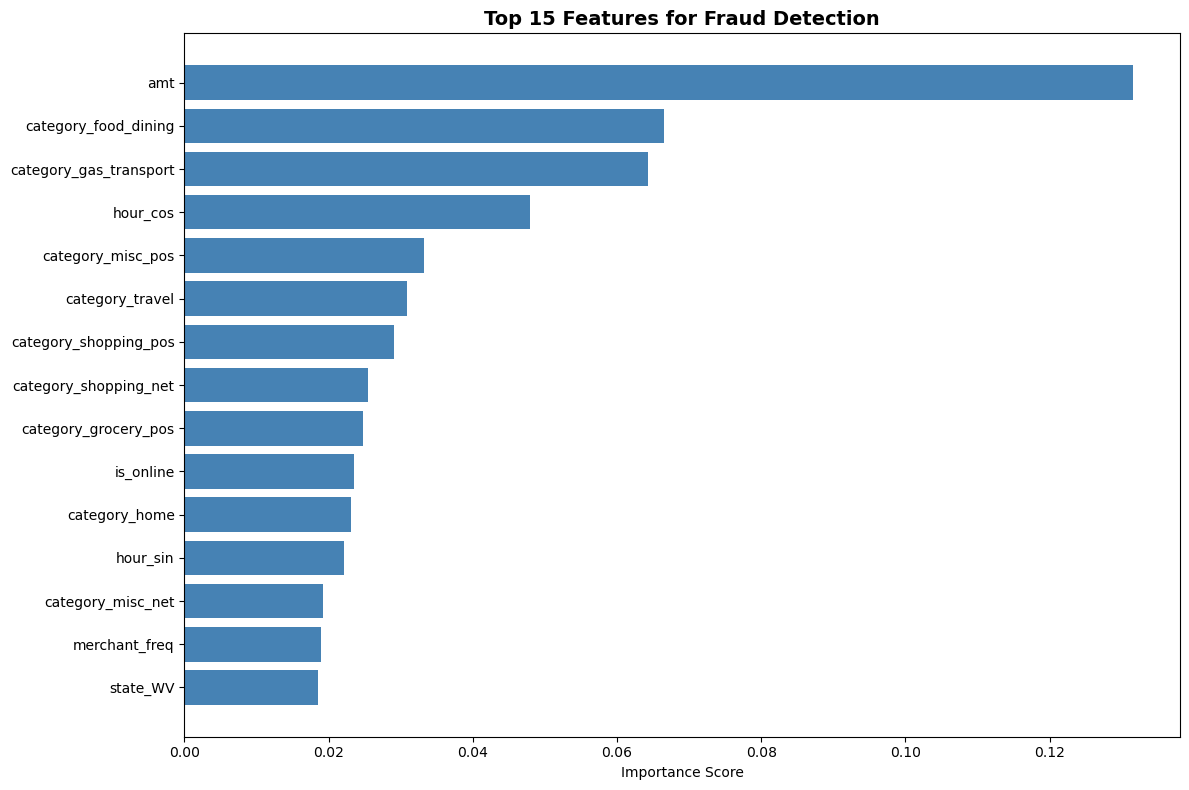


💡 Insight: Transaction amount, online indicator, and time features
   are among the most important fraud predictors.


In [33]:
# Get feature importance from trained model
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False)

# Display top 15 features
print("Top 15 Most Important Features:")
print(feature_importance.head(15).to_string(index=False))

# Visualize
plt.figure(figsize=(12, 8))
top_features = feature_importance.head(15)
plt.barh(range(len(top_features)), top_features['importance'], color='steelblue')
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Importance Score')
plt.title('Top 15 Features for Fraud Detection', fontsize=14, weight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print("\n💡 Insight: Transaction amount, online indicator, and time features")
print("   are among the most important fraud predictors.")


## 8. Key Findings & Business Impact 

In [34]:
# Calculate final business metrics
from sklearn.metrics import classification_report

final_report = classification_report(y_test, y_test_pred, output_dict=True)

fraud_recall = final_report['1']['recall']
fraud_precision = final_report['1']['precision']
false_negatives = cm[1][0]
true_positives = cm[1][1]

print("="*60)
print("BUSINESS IMPACT SUMMARY")
print("="*60)
print(f"\n📊 Model Performance:")
print(f"   • Catching {fraud_recall*100:.1f}% of all fraud cases (Recall)")
print(f"   • {fraud_precision*100:.1f}% of fraud alerts are genuine (Precision)")
print(f"   • ROC-AUC: {roc_auc_score(y_test, y_test_prob):.4f} (Excellent)")

print(f"\n💰 Financial Impact:")
print(f"   • Frauds Caught: {true_positives:,}")
print(f"   • Frauds Missed: {false_negatives:,} (opportunities for improvement)")
print(f"   • False Alarms: {cm[0][1]:,} (may inconvenience customers)")

print(f"\n🎯 Key Fraud Indicators:")
print(f"   • Transaction amount (higher amounts = higher risk)")
print(f"   • Online transactions (card-not-present)")
print(f"   • Time of transaction (unusual hours)")
print(f"   • Merchant frequency (new/rare merchants)")


print("="*60)


BUSINESS IMPACT SUMMARY

📊 Model Performance:
   • Catching 92.1% of all fraud cases (Recall)
   • 51.6% of fraud alerts are genuine (Precision)
   • ROC-AUC: 0.9974 (Excellent)

💰 Financial Impact:
   • Frauds Caught: 395
   • Frauds Missed: 34 (opportunities for improvement)
   • False Alarms: 370 (may inconvenience customers)

🎯 Key Fraud Indicators:
   • Transaction amount (higher amounts = higher risk)
   • Online transactions (card-not-present)
   • Time of transaction (unusual hours)
   • Merchant frequency (new/rare merchants)


## 9. Conclusion & Learnings

This project demonstrated end-to-end fraud detection in the BFSI domain, covering:
- **Data preprocessing** and feature engineering
- Handling **highly imbalanced** datasets
- Building and evaluating **XGBoost** models
- Interpreting results in **business context**

**Key Takeaways:**
1. **Class imbalance** is inherent in fraud detection - use techniques like class weighting
2. **Feature engineering** (cyclical encoding, distance calculation) significantly improves model performance
3. **Recall** is more important than precision in fraud - missing a fraud is costlier than a false alarm
4. **Model interpretability** (feature importance) builds trust and guides business decisions

In [35]:
# End of notebook
print("✅ Analysis complete!")
print("\n📌 This notebook demonstrated:")
print("   1. Data preprocessing and feature engineering for fraud detection")
print("   2. Handling imbalanced datasets with class weighting")
print("   3. Building XGBoost models with proper evaluation")
print("   4. Interpreting model results in business context")



✅ Analysis complete!

📌 This notebook demonstrated:
   1. Data preprocessing and feature engineering for fraud detection
   2. Handling imbalanced datasets with class weighting
   3. Building XGBoost models with proper evaluation
   4. Interpreting model results in business context
